In [76]:
include("/home/javier/Desktop/alpcah/alpcah.jl");

In [1]:
include("/home/javier/Desktop/alpcah/alpcah.jl")
using Plots
using Random
using Distributions
using LinearAlgebra
#include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
N = 500 # total points
D = 100 # ambient space
d = 10 # subspace rank
σ1 = 0.5 # noise level 1
σ2 = 10 # noise level 2
goodpts = 10 # good points out of total
trials = 25
X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    # older code projecting points U1*U1'*rand(Uniform(-100,100),D)
    X[:,k] =  U1*rand(Uniform(-33,33),d) 
    #X[:,k] =  U1*rand(Normal(0,19.05),d)
end
for j=1:N
        if (j<= goodpts)
            Y[:,j] = X[:,j] + rand(Normal(0,σ1),D)
            Π[j] = σ1^2
        else
            Y[:,j] = X[:,j] + rand(Normal(0,σ2),D)
            Π[j] = σ2^2
        end
end

In [2]:
XL = []
YL = []
for i = 1:trials
    rng = Random.seed!(i)
    X0 = zeros(D,N)
    Y0 = zeros(D,N)
    for k = 1:N
    # older code projecting points U1*U1'*rand(Uniform(-100,100),D)
        X0[:,k] =  U1*rand(Uniform(-33,33),d) 
        #X0[:,k] =  U1*rand(Normal(0,19.05),d)
    end
    push!(XL,X0)
    for j=1:N
        if (j<= goodpts)
            Y0[:,j] = X0[:,j] + rand(Normal(0,σ1),D)
        else
            Y0[:,j] = X0[:,j] + rand(Normal(0,σ2),D)
        end
    end
    push!(YL,Y0)
end

In [3]:
function weightedPCA(Y , w, k)
    L = unique(w)
    Σ = zeros(size(Y)[1], size(Y)[1])
    for i=1:length(L)
        ind = findall(x -> x == L[i], w)
        Σ = Σ + L[i]*(Y[:,ind]*Y[:,ind]')
    end
    U = reverse(eigvecs(Σ), dims=2)
    Ȳ = reshape(shuffle(Y[:]), size(Y))
    U_Y = svd(Y).S
    U_Ȳ = svd(Ȳ).S
    #k = floor(Int, norm(U_Y .> U_Ȳ, 0))
    return U[:,1:k] #, k
end
U_WPCA = weightedPCA(Y,Π.^-1,d);

In [4]:
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y[:,1:goodpts])
push!(heppCAT_matrix, Y[:,(goodpts+1):end])
heppCAT_nogroups = []
for i = 1:N
    push!(heppCAT_nogroups, Y[:,i])
end
homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
heppCAT = heppcat(heppCAT_matrix,d,1000;varfloor=1e-9)  
heppCAT_NOG = heppcat(heppCAT_nogroups,d,1000;varfloor=1e-9)
error_heppcat = norm(heppCAT.U*heppCAT.U' - U1*U1', 2)/norm(U1*U1', 2)
error_heppcat_NOG = norm(heppCAT_NOG.U*heppCAT_NOG.U' - U1*U1', 2)/norm(U1*U1', 2)
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)
error_wpca = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)

0.1771741400570271

In [5]:
error_homoppca

0.34124888281490406

In [6]:
error_heppcat

0.21863476713286625

In [7]:
error_heppcat_NOG

0.21834150779667102

In [8]:
function HPCA_UNKNOWN_ADMM(Y, λr, N, μ, ρ, d, U_init)
    #X = zeros(size(Y))
    #Z = zeros(size(X))
    X = deepcopy(U_init*U_init'*Y)
    Z = deepcopy(Y-X)
    var = 0
    if (U_init == 0)
        #heppCAT_matrix = []
        #goodpts = 10
        #push!(heppCAT_matrix, Y[:,1:goodpts])
        #push!(heppCAT_matrix, Y[:,(goodpts+1):end])
        #var = heppcat(heppCAT_matrix,N,0).v[1]*vec(ones(size(Y)[2],1)) # homo pca
        var = vec(ones(100,1))
    else
        var = W_NO_GROUPS(Y,X)
    end
    Π = diagm(var.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-7) || (count <100))
    #for i = 1:1000
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        var = W_NO_GROUPS(Y,X)
        Π = diagm(var.^-1)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:d]   
    return U
end

function W_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)'*(Y-L))
    Π = max.(Π,1e-9)
    return Π
end

function W_ALL_GROUPS(Y, L)
    Π = vec(zeros(size(Y)[2],1))
    d = size(Y)[1]
    goodpts = 5
    N = 100
    Π[1:goodpts] .= (1/(d*goodpts))*norm(Y[:,1:goodpts]-L[:,1:goodpts],2)^2
    Π[(goodpts+1):end] .= (1/(d*(N-goodpts)))*norm(Y[:,(goodpts+1):end]-L[:,(goodpts+1):end],2)^2
    Π = max.(Π,1e-9)
    return Π
end

W_ALL_GROUPS (generic function with 1 method)

In [9]:
wpca_list = []
heppcat_list = []
homopca_list = []
hpca_list = []
#hpca_nuclear = []
λr = vcat(0.0:5:75.0)
λr[1] = 0.1
for i=1:trials
    println(i)
    flush(stdout)
    homoPCA_U = svd(YL[i]).U[:,1:10]
    errorPCA = norm(homoPCA_U*homoPCA_U' - U1*U1',2)/norm(U1*U1',2)
    push!(homopca_list, errorPCA)
    U_WPCA = weightedPCA(YL[i],Π.^-1,d);
    errorWPCA = norm(U_WPCA*U_WPCA' - U1*U1',2)/norm(U1*U1',2)
    push!(wpca_list, errorWPCA)
    heppCAT_nogroups = []
    T = YL[i]
    for k = 1:N
        push!(heppCAT_nogroups, T[:,k])
    end
    heppCAT_NOG = heppcat(heppCAT_nogroups,d,1000;varfloor=1e-9)
    error_heppcat_NOG = norm(heppCAT_NOG.U*heppCAT_NOG.U' - U1*U1', 2)/norm(U1*U1', 2)
    push!(heppcat_list,error_heppcat_NOG)
    error_hpca_admm = zeros(size(λr))
    #error_hpca_nuclear = zeros(size(λr))
    for j=1:length(λr)
        U_HPCA = HPCA_UNKNOWN_ADMM(YL[i], λr[j], 10, 0.01, 1.01, d, homoPCA_U)  
        error_hpca_admm[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
        #U_HPCA = HPCA_UNKNOWN_ADMM(YL[i], λr[j], 0, 0.01, 1.01, d, homoPCA_U)  
        #error_hpca_nuclear[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
    end
    push!(hpca_list, error_hpca_admm)
    #push!(hpca_nuclear, error_hpca_nuclear)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [77]:
hpca_lr_list = []
for i=1:trials
    #println(i)
    #flush(stdout)
    alpcahLR_U =  ALPCAH_UNKNOWN_ALTMIN(YL[i], 10)
    erroralpcahLR = norm(alpcahLR_U*alpcahLR_U' - U1*U1',2)/norm(U1*U1',2)
    push!(hpca_lr_list, erroralpcahLR)
end

In [78]:
heppcat_mean = mean(heppcat_list);
homopca_mean = mean(homopca_list)
wpca_mean = mean(wpca_list);
hpca_mean = mean(hpca_list);
hpca_lr_mean = mean(hpca_lr_list);
#hpca_mean_nuclear = mean(hpca_nuclear);

In [79]:
heppcat_std = std(heppcat_list);
homopca_std = std(homopca_list)
wpca_std = std(wpca_list);
hpca_std = std(hpca_list);
hpca_lr_std = std(hpca_lr_list);

In [80]:
colors = theme_palette(:auto).colors

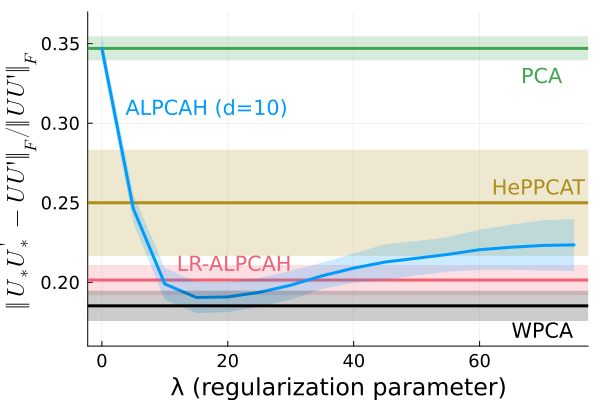

In [108]:
using LaTeXStrings
λr = vcat(0:5:75)
plot(xlabel="λ (regularization parameter)",ylims=(0.16,0.37),ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F")
plot!(legend_position=:topright, legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18, legend=:false)
hline!([homopca_mean],ribbon=homopca_std,c=colors[3], fillalpha = 0.2,linewidth=3, label="PPCA")
hline!([heppcat_mean],ribbon=heppcat_std, c=colors[5], fillalpha = 0.2, linewidth=3, label="HePPCAT")
hline!([hpca_lr_mean],ribbon=hpca_lr_std, c=colors[end-2], fillalpha = 0.2, linewidth=3, label="LRALPCAH")
maxValue = vec(maximum(reduce(vcat,transpose.(hpca_list)),dims=1))
minValue = vec(minimum(reduce(vcat,transpose.(hpca_list)),dims=1))
plot!(λr,hpca_mean, ribbon=hpca_std, fillalpha = 0.2, c=colors[1], linewidth=3, label="HPCA")
hline!([wpca_mean],ribbon=wpca_std, c=:black, linewidth=3,fillalpha = 0.2, label="WPCA")
annotate!(70, 0.33, "PCA", colors[3])
annotate!(69.5, 0.26, "HePPCAT", colors[5])
annotate!(16.5, 0.31, "ALPCAH (d=10)", colors[1])
annotate!(21, 0.212, "LR-ALPCAH", colors[end-2])
annotate!(70, 0.17, "WPCA", :black)
#savefig("alpcah_absolute_error_unknown.pdf")

In [44]:
dataHPCA = reduce(vcat,transpose.(hpca_list));
dataPCA = reduce(vcat,transpose.(homopca_list));
dataHEPPCAT = reduce(vcat,transpose.(heppcat_list));
dataWPCA = reduce(vcat,transpose.(wpca_list));

In [45]:
using JLD
save("unknown_data.jld", "ALPCAH",dataHPCA, "PCA", dataPCA, "WPCA", dataWPCA, "HEPPCAT", dataHEPPCAT)

In [ ]:
# calculate CI at some point